In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/HW4/hw4_data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: hw4_data/mini/train/n0207436700000661.jpg  
  inflating: hw4_data/mini/train/n0461250400000869.jpg  
  inflating: hw4_data/mini/train/n0216545600000546.jpg  
  inflating: hw4_data/mini/train/n0451500300001128.jpg  
  inflating: hw4_data/mini/train/n0438903300000330.jpg  
  inflating: hw4_data/mini/train/n0388860500000891.jpg  
  inflating: hw4_data/mini/train/n0208986700000124.jpg  
  inflating: hw4_data/mini/train/n0427554800000800.jpg  
  inflating: hw4_data/mini/train/n0279516900000391.jpg  
  inflating: hw4_data/mini/train/n0385406500000270.jpg  
  inflating: hw4_data/mini/train/n0367648300001190.jpg  
  inflating: hw4_data/mini/train/n0304769000000851.jpg  
  inflating: hw4_data/mini/train/n0177008100000336.jpg  
  inflating: hw4_data/mini/train/n0268717200001040.jpg  
  inflating: hw4_data/mini/train/n0333714000000408.jpg  
  inflating: hw4_data/mini/train/n0210808900000686.jpg  
  inflating: hw4_data/mini/train/n1305456000000727.jpg  
  inflatin

In [3]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageEnhance, ImageOps
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.utils import save_image
from tqdm import tqdm
import cv2

In [4]:
!pip install byol-pytorch
!pip install pytorch-lightning
!pip install pillow

     |████████████████████████████████| 526 kB 8.8 MB/s 
     |████████████████████████████████| 132 kB 76.7 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 332 kB 57.9 MB/s 
     |████████████████████████████████| 829 kB 54.3 MB/s 
     |████████████████████████████████| 1.1 MB 67.6 MB/s 
     |████████████████████████████████| 160 kB 79.9 MB/s 
     |████████████████████████████████| 192 kB 97.2 MB/s 
     |████████████████████████████████| 271 kB 73.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=818fa83de9560679541cc0ff2639fd7f76d982dac5c7e374208be4c1d5f10f37
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
!python3 /content/drive/MyDrive/HW4/byol.py --image_folder /content/hw4_data/mini/train

38400 images found
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name    | Type | Params
---------------------------------
0 | learner | BYOL | 70.0 M
---------------------------------
35.5 M    Trainable params
34.5 M    Non-trainable params
70.0 M    Total params
280.103   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/MyDrive/HW4/BYOL exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Epoch 39: 100% 1200/1200 [15:25<00:00,  1.30it/s, loss=0.194, v_num=0]


In [16]:


class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.Linear(128, 65)
        )
    def forward(self, x):
        x = self.fc(x)
        return x

class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, fix=False):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fix = fix
        if self.fix:
          for param in modelA.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x1)
        return x2

resnet = torchvision.models.resnet50(pretrained=False)

resnet.load_state_dict(torch.load('/content/drive/MyDrive/HW4/self_model/backbone.pt'))
model = MyEnsemble(resnet, classifier(), fix=False)



In [6]:


device = "cuda" if torch.cuda.is_available() else "cpu"

# model.fc = nn.Linear(2048, 65)

model = model.to(device)

In [10]:
model

MyEnsemble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [7]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

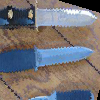

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(100),
])

a = np.random.choice(os.listdir('/content/hw4_data/office/train'))
img = Image.open('/content/hw4_data/office/train/'+a)
train_tfm(img)

In [21]:
label_dic = {}
csv = pd.read_csv('/content/hw4_data/office/train.csv')
c=0
for i in list(set(csv['label'].to_list())):
  label_dic[i] = c
  c+=1
label_dic

{'Alarm_Clock': 14,
 'Backpack': 27,
 'Batteries': 36,
 'Bed': 46,
 'Bike': 38,
 'Bottle': 62,
 'Bucket': 41,
 'Calculator': 26,
 'Calendar': 1,
 'Candles': 25,
 'Chair': 51,
 'Clipboards': 20,
 'Computer': 59,
 'Couch': 10,
 'Curtains': 22,
 'Desk_Lamp': 32,
 'Drill': 7,
 'Eraser': 40,
 'Exit_Sign': 11,
 'Fan': 34,
 'File_Cabinet': 31,
 'Flipflops': 24,
 'Flowers': 35,
 'Folder': 3,
 'Fork': 5,
 'Glasses': 21,
 'Hammer': 9,
 'Helmet': 23,
 'Kettle': 17,
 'Keyboard': 50,
 'Knives': 49,
 'Lamp_Shade': 30,
 'Laptop': 63,
 'Marker': 19,
 'Monitor': 42,
 'Mop': 56,
 'Mouse': 52,
 'Mug': 18,
 'Notebook': 60,
 'Oven': 47,
 'Pan': 12,
 'Paper_Clip': 58,
 'Pen': 57,
 'Pencil': 54,
 'Postit_Notes': 37,
 'Printer': 8,
 'Push_Pin': 13,
 'Radio': 6,
 'Refrigerator': 0,
 'Ruler': 43,
 'Scissors': 44,
 'Screwdriver': 64,
 'Shelf': 28,
 'Sink': 16,
 'Sneakers': 55,
 'Soda': 29,
 'Speaker': 45,
 'Spoon': 61,
 'TV': 39,
 'Table': 2,
 'Telephone': 4,
 'ToothBrush': 33,
 'Toys': 15,
 'Trash_Can': 48,
 'W

In [9]:
label_dic = {'Alarm_Clock': 14,
 'Backpack': 27,
 'Batteries': 36,
 'Bed': 46,
 'Bike': 38,
 'Bottle': 62,
 'Bucket': 41,
 'Calculator': 26,
 'Calendar': 1,
 'Candles': 25,
 'Chair': 51,
 'Clipboards': 20,
 'Computer': 59,
 'Couch': 10,
 'Curtains': 22,
 'Desk_Lamp': 32,
 'Drill': 7,
 'Eraser': 40,
 'Exit_Sign': 11,
 'Fan': 34,
 'File_Cabinet': 31,
 'Flipflops': 24,
 'Flowers': 35,
 'Folder': 3,
 'Fork': 5,
 'Glasses': 21,
 'Hammer': 9,
 'Helmet': 23,
 'Kettle': 17,
 'Keyboard': 50,
 'Knives': 49,
 'Lamp_Shade': 30,
 'Laptop': 63,
 'Marker': 19,
 'Monitor': 42,
 'Mop': 56,
 'Mouse': 52,
 'Mug': 18,
 'Notebook': 60,
 'Oven': 47,
 'Pan': 12,
 'Paper_Clip': 58,
 'Pen': 57,
 'Pencil': 54,
 'Postit_Notes': 37,
 'Printer': 8,
 'Push_Pin': 13,
 'Radio': 6,
 'Refrigerator': 0,
 'Ruler': 43,
 'Scissors': 44,
 'Screwdriver': 64,
 'Shelf': 28,
 'Sink': 16,
 'Sneakers': 55,
 'Soda': 29,
 'Speaker': 45,
 'Spoon': 61,
 'TV': 39,
 'Table': 2,
 'Telephone': 4,
 'ToothBrush': 33,
 'Toys': 15,
 'Trash_Can': 48,
 'Webcam': 53}

In [10]:
class Image_Dataset(Dataset):
    def __init__(self, root, train=True, trans=None):
      self.train = train
      self.root = root
      self.transform = trans
      self.csv_file = pd.read_csv(self.root + '%s.csv'%self.train)

    def __getitem__(self, index):
      self.img = Image.open(os.path.join(self.root+self.train, self.csv_file['filename'].iloc[index])).convert('RGB')
      if (self.train == 'train') | (self.train == 'val'):
        self.img = self.transform(self.img)
        self.label = label_dic[self.csv_file['label'].iloc[index]]
        return self.img, int(self.label)
      else:
        self.img = self.transform(self.img)
        return (self.img)
    def __len__(self):
      return len(self.csv_file)

batch_size = 16

train_set = Image_Dataset('/content/hw4_data/office/', train='train', trans=train_tfm)
valid_set = Image_Dataset('/content/hw4_data/office/', train='val', trans=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
n_epochs = 90

best = {0.1:1, 0.2:2, 0.15:3}
his_train_loss = []
his_val_loss = []
his_train_acc = []
his_val_acc = []

for epoch in range(n_epochs):

    # We apply learning rate schedule. The learning rate is reduced by half after every 3 epoch training
    if epoch % 5 == 0 and epoch != 0:
        for group in optimizer.param_groups:
            group['lr'] *= 0.7

    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}")
    print(optimizer.param_groups[0]['lr'])

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
        #   inputs = feature_extractor(images=imgs, return_tensors="pt")
        #   outputs = model(**inputs.to(device))
            logits = model(imgs.to(device))

        # logits = outputs.logits
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    # Print the information.

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] val_loss = {valid_loss:.5f}, val_acc = {valid_acc:.5f}")

    if valid_acc > min(best):
      del_pth = best.pop(min(list(best.keys())))
      best[valid_acc] = epoch
      try:
        os.system('rm /content/drive/MyDrive/HW4/self_model/resnet50_v1_%s.pth'%del_pth)
      except:
        pass
      torch.save(model.state_dict(),  '/content/drive/MyDrive/HW4/self_model/resnet50_v1_%s.pth'%epoch) # 'xxx.pth' #保存模型


  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 247/247 [01:07<00:00,  3.68it/s]


[ Train | 001/090 ] train_loss = 3.84657, train_acc = 0.08684
0.01


100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


[ Valid | 001/090 ] val_loss = 3.89651, val_acc = 0.11218


100%|██████████| 247/247 [01:07<00:00,  3.67it/s]


[ Train | 002/090 ] train_loss = 3.36653, train_acc = 0.16404
0.01


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


[ Valid | 002/090 ] val_loss = 3.33926, val_acc = 0.21074


100%|██████████| 247/247 [01:05<00:00,  3.77it/s]


[ Train | 003/090 ] train_loss = 3.16017, train_acc = 0.19668
0.01


100%|██████████| 26/26 [00:07<00:00,  3.63it/s]


[ Valid | 003/090 ] val_loss = 3.35873, val_acc = 0.19231


100%|██████████| 247/247 [01:06<00:00,  3.70it/s]


[ Train | 004/090 ] train_loss = 3.07565, train_acc = 0.21945
0.01


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


[ Valid | 004/090 ] val_loss = 3.16538, val_acc = 0.22756


100%|██████████| 247/247 [01:06<00:00,  3.72it/s]


[ Train | 005/090 ] train_loss = 2.95966, train_acc = 0.23713
0.01


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


[ Valid | 005/090 ] val_loss = 2.81894, val_acc = 0.25481


100%|██████████| 247/247 [01:05<00:00,  3.76it/s]


[ Train | 006/090 ] train_loss = 2.76095, train_acc = 0.26707
0.006999999999999999


100%|██████████| 26/26 [00:07<00:00,  3.58it/s]


[ Valid | 006/090 ] val_loss = 3.15863, val_acc = 0.26843


100%|██████████| 247/247 [01:05<00:00,  3.77it/s]


[ Train | 007/090 ] train_loss = 2.68306, train_acc = 0.28853
0.006999999999999999


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


[ Valid | 007/090 ] val_loss = 2.57685, val_acc = 0.33253


100%|██████████| 247/247 [01:05<00:00,  3.75it/s]


[ Train | 008/090 ] train_loss = 2.60876, train_acc = 0.30928
0.006999999999999999


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


[ Valid | 008/090 ] val_loss = 2.47122, val_acc = 0.34054


100%|██████████| 247/247 [01:06<00:00,  3.73it/s]


[ Train | 009/090 ] train_loss = 2.55123, train_acc = 0.31636
0.006999999999999999


100%|██████████| 26/26 [00:07<00:00,  3.65it/s]


[ Valid | 009/090 ] val_loss = 2.54456, val_acc = 0.35256


100%|██████████| 247/247 [01:06<00:00,  3.74it/s]


[ Train | 010/090 ] train_loss = 2.48392, train_acc = 0.33942
0.006999999999999999


100%|██████████| 26/26 [00:07<00:00,  3.37it/s]


[ Valid | 010/090 ] val_loss = 2.38287, val_acc = 0.34295


100%|██████████| 247/247 [01:06<00:00,  3.73it/s]


[ Train | 011/090 ] train_loss = 2.35270, train_acc = 0.36594
0.004899999999999999


100%|██████████| 26/26 [00:07<00:00,  3.61it/s]


[ Valid | 011/090 ] val_loss = 2.40062, val_acc = 0.38301


100%|██████████| 247/247 [01:06<00:00,  3.72it/s]


[ Train | 012/090 ] train_loss = 2.31812, train_acc = 0.36753
0.004899999999999999


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


[ Valid | 012/090 ] val_loss = 2.22932, val_acc = 0.41987


100%|██████████| 247/247 [01:05<00:00,  3.75it/s]


[ Train | 013/090 ] train_loss = 2.25345, train_acc = 0.38775
0.004899999999999999


100%|██████████| 26/26 [00:07<00:00,  3.53it/s]


[ Valid | 013/090 ] val_loss = 2.28586, val_acc = 0.42628


100%|██████████| 247/247 [01:05<00:00,  3.75it/s]


[ Train | 014/090 ] train_loss = 2.20704, train_acc = 0.39459
0.004899999999999999


100%|██████████| 26/26 [00:07<00:00,  3.61it/s]


[ Valid | 014/090 ] val_loss = 2.34999, val_acc = 0.40224


100%|██████████| 247/247 [01:05<00:00,  3.78it/s]


[ Train | 015/090 ] train_loss = 2.18139, train_acc = 0.40518
0.004899999999999999


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


[ Valid | 015/090 ] val_loss = 2.37327, val_acc = 0.40705


100%|██████████| 247/247 [01:04<00:00,  3.81it/s]


[ Train | 016/090 ] train_loss = 2.09362, train_acc = 0.42034
0.003429999999999999


100%|██████████| 26/26 [00:07<00:00,  3.65it/s]


[ Valid | 016/090 ] val_loss = 2.14565, val_acc = 0.44231


100%|██████████| 247/247 [01:05<00:00,  3.78it/s]


[ Train | 017/090 ] train_loss = 2.01953, train_acc = 0.44725
0.003429999999999999


100%|██████████| 26/26 [00:07<00:00,  3.54it/s]


[ Valid | 017/090 ] val_loss = 2.22635, val_acc = 0.42628


100%|██████████| 247/247 [01:05<00:00,  3.79it/s]


[ Train | 018/090 ] train_loss = 2.00621, train_acc = 0.44875
0.003429999999999999


100%|██████████| 26/26 [00:07<00:00,  3.63it/s]


[ Valid | 018/090 ] val_loss = 2.23160, val_acc = 0.43830


100%|██████████| 247/247 [01:05<00:00,  3.79it/s]


[ Train | 019/090 ] train_loss = 1.96702, train_acc = 0.45076
0.003429999999999999


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


[ Valid | 019/090 ] val_loss = 2.19695, val_acc = 0.45833


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 020/090 ] train_loss = 1.97821, train_acc = 0.44799
0.003429999999999999


100%|██████████| 26/26 [00:07<00:00,  3.61it/s]


[ Valid | 020/090 ] val_loss = 2.10319, val_acc = 0.44792


100%|██████████| 247/247 [01:05<00:00,  3.80it/s]


[ Train | 021/090 ] train_loss = 1.85907, train_acc = 0.47729
0.002400999999999999


100%|██████████| 26/26 [00:06<00:00,  3.80it/s]


[ Valid | 021/090 ] val_loss = 2.11284, val_acc = 0.45593


100%|██████████| 247/247 [01:04<00:00,  3.86it/s]


[ Train | 022/090 ] train_loss = 1.80945, train_acc = 0.48951
0.002400999999999999


100%|██████████| 26/26 [00:07<00:00,  3.63it/s]


[ Valid | 022/090 ] val_loss = 2.16259, val_acc = 0.46955


100%|██████████| 247/247 [01:05<00:00,  3.79it/s]


[ Train | 023/090 ] train_loss = 1.82784, train_acc = 0.47986
0.002400999999999999


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


[ Valid | 023/090 ] val_loss = 2.11708, val_acc = 0.44071


100%|██████████| 247/247 [01:04<00:00,  3.84it/s]


[ Train | 024/090 ] train_loss = 1.78158, train_acc = 0.49330
0.002400999999999999


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


[ Valid | 024/090 ] val_loss = 2.04904, val_acc = 0.47196


100%|██████████| 247/247 [01:04<00:00,  3.85it/s]


[ Train | 025/090 ] train_loss = 1.75662, train_acc = 0.50542
0.002400999999999999


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


[ Valid | 025/090 ] val_loss = 2.08603, val_acc = 0.49119


100%|██████████| 247/247 [01:03<00:00,  3.89it/s]


[ Train | 026/090 ] train_loss = 1.71197, train_acc = 0.51834
0.0016806999999999992


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


[ Valid | 026/090 ] val_loss = 2.13465, val_acc = 0.49679


100%|██████████| 247/247 [01:04<00:00,  3.86it/s]


[ Train | 027/090 ] train_loss = 1.66964, train_acc = 0.52335
0.0016806999999999992


100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


[ Valid | 027/090 ] val_loss = 2.09929, val_acc = 0.49199


100%|██████████| 247/247 [01:03<00:00,  3.88it/s]


[ Train | 028/090 ] train_loss = 1.64317, train_acc = 0.52338
0.0016806999999999992


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


[ Valid | 028/090 ] val_loss = 2.13886, val_acc = 0.49760


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 029/090 ] train_loss = 1.65910, train_acc = 0.53074
0.0016806999999999992


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


[ Valid | 029/090 ] val_loss = 2.07098, val_acc = 0.51122


100%|██████████| 247/247 [01:03<00:00,  3.89it/s]


[ Train | 030/090 ] train_loss = 1.64998, train_acc = 0.52392
0.0016806999999999992


100%|██████████| 26/26 [00:06<00:00,  3.80it/s]


[ Valid | 030/090 ] val_loss = 1.96238, val_acc = 0.50641


100%|██████████| 247/247 [01:03<00:00,  3.88it/s]


[ Train | 031/090 ] train_loss = 1.58762, train_acc = 0.53914
0.0011764899999999994


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


[ Valid | 031/090 ] val_loss = 2.05521, val_acc = 0.50080


100%|██████████| 247/247 [01:03<00:00,  3.88it/s]


[ Train | 032/090 ] train_loss = 1.55104, train_acc = 0.55580
0.0011764899999999994


100%|██████████| 26/26 [00:06<00:00,  3.82it/s]


[ Valid | 032/090 ] val_loss = 2.11948, val_acc = 0.51282


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 033/090 ] train_loss = 1.53121, train_acc = 0.55530
0.0011764899999999994


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


[ Valid | 033/090 ] val_loss = 2.10724, val_acc = 0.50240


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 034/090 ] train_loss = 1.53979, train_acc = 0.56012
0.0011764899999999994


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


[ Valid | 034/090 ] val_loss = 2.02075, val_acc = 0.49599


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 035/090 ] train_loss = 1.54898, train_acc = 0.55152
0.0011764899999999994


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


[ Valid | 035/090 ] val_loss = 2.07832, val_acc = 0.47837


100%|██████████| 247/247 [01:03<00:00,  3.87it/s]


[ Train | 036/090 ] train_loss = 1.47466, train_acc = 0.56871
0.0008235429999999996


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


[ Valid | 036/090 ] val_loss = 2.08474, val_acc = 0.51603


100%|██████████| 247/247 [01:04<00:00,  3.83it/s]


[ Train | 037/090 ] train_loss = 1.46852, train_acc = 0.57353
0.0008235429999999996


100%|██████████| 26/26 [00:07<00:00,  3.55it/s]


[ Valid | 037/090 ] val_loss = 2.05408, val_acc = 0.50721


100%|██████████| 247/247 [01:06<00:00,  3.73it/s]


[ Train | 038/090 ] train_loss = 1.47021, train_acc = 0.57402
0.0008235429999999996


100%|██████████| 26/26 [00:07<00:00,  3.67it/s]


[ Valid | 038/090 ] val_loss = 2.12868, val_acc = 0.51042


100%|██████████| 247/247 [01:04<00:00,  3.84it/s]


[ Train | 039/090 ] train_loss = 1.45213, train_acc = 0.57272
0.0008235429999999996


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


[ Valid | 039/090 ] val_loss = 2.13874, val_acc = 0.50401


100%|██████████| 247/247 [01:04<00:00,  3.84it/s]


[ Train | 040/090 ] train_loss = 1.48768, train_acc = 0.55990
0.0008235429999999996


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


[ Valid | 040/090 ] val_loss = 2.10414, val_acc = 0.51362


100%|██████████| 247/247 [01:04<00:00,  3.82it/s]


[ Train | 041/090 ] train_loss = 1.43964, train_acc = 0.58031
0.0005764800999999997


100%|██████████| 26/26 [00:07<00:00,  3.53it/s]


[ Valid | 041/090 ] val_loss = 2.15494, val_acc = 0.49760


100%|██████████| 247/247 [01:04<00:00,  3.85it/s]


[ Train | 042/090 ] train_loss = 1.42448, train_acc = 0.58463
0.0005764800999999997


100%|██████████| 26/26 [00:07<00:00,  3.64it/s]


[ Valid | 042/090 ] val_loss = 2.09329, val_acc = 0.51042


100%|██████████| 247/247 [01:04<00:00,  3.81it/s]


[ Train | 043/090 ] train_loss = 1.42639, train_acc = 0.57627
0.0005764800999999997


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


[ Valid | 043/090 ] val_loss = 2.04911, val_acc = 0.52804


100%|██████████| 247/247 [01:04<00:00,  3.85it/s]


[ Train | 044/090 ] train_loss = 1.42092, train_acc = 0.57959
0.0005764800999999997


100%|██████████| 26/26 [00:06<00:00,  3.82it/s]


[ Valid | 044/090 ] val_loss = 2.04425, val_acc = 0.51122


100%|██████████| 247/247 [01:04<00:00,  3.82it/s]


[ Train | 045/090 ] train_loss = 1.38723, train_acc = 0.59480
0.0005764800999999997


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


[ Valid | 045/090 ] val_loss = 2.14854, val_acc = 0.50881


100%|██████████| 247/247 [01:05<00:00,  3.79it/s]


[ Train | 046/090 ] train_loss = 1.38190, train_acc = 0.59710
0.00040353606999999974


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


[ Valid | 046/090 ] val_loss = 2.06322, val_acc = 0.52484


100%|██████████| 247/247 [01:05<00:00,  3.75it/s]


[ Train | 047/090 ] train_loss = 1.39951, train_acc = 0.59658
0.00040353606999999974


100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


[ Valid | 047/090 ] val_loss = 2.07334, val_acc = 0.51763


100%|██████████| 247/247 [01:05<00:00,  3.77it/s]


[ Train | 048/090 ] train_loss = 1.38175, train_acc = 0.59352
0.00040353606999999974


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


[ Valid | 048/090 ] val_loss = 2.10640, val_acc = 0.52804


100%|██████████| 247/247 [01:04<00:00,  3.82it/s]


[ Train | 049/090 ] train_loss = 1.36520, train_acc = 0.59459
0.00040353606999999974


100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


[ Valid | 049/090 ] val_loss = 2.23727, val_acc = 0.49599


100%|██████████| 247/247 [01:05<00:00,  3.77it/s]


[ Train | 050/090 ] train_loss = 1.36679, train_acc = 0.59855
0.00040353606999999974


100%|██████████| 26/26 [00:07<00:00,  3.48it/s]


[ Valid | 050/090 ] val_loss = 2.14271, val_acc = 0.53365


100%|██████████| 247/247 [01:04<00:00,  3.82it/s]


[ Train | 051/090 ] train_loss = 1.36022, train_acc = 0.60061
0.0002824752489999998


 73%|███████▎  | 19/26 [00:06<00:01,  4.56it/s]

In [38]:
import torch as t
import torchvision


model1 = t.load('/content/drive/MyDrive/HW4/self_model/resnet50_v1_49.pth')
model2 = t.load('/content/drive/MyDrive/HW4/self_model/resnet50_v1_54.pth')
model3 = t.load('/content/drive/MyDrive/HW4/self_model/resnet50_v1_56.pth')

for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key]) / 3

device = "cuda" if torch.cuda.is_available() else "cpu"

n_classes = 65


backcone = torchvision.models.resnet50(pretrained=False)

ensemble = MyEnsemble(backcone, classifier(), fix=False)

ensemble = ensemble.to(device)
ensemble.load_state_dict(model1)

t.save(ensemble.state_dict(),  '/content/drive/MyDrive/HW4/self_model/resnet50_ensemble.pth')


In [18]:
backcone = torchvision.models.resnet50(pretrained=False)
ensemble = MyEnsemble(backcone, classifier(), fix=False)
ensemble.load_state_dict(t.load('/content/drive/MyDrive/HW4/self_model/resnet50_ensemble.pth'))
ensemble = ensemble.to(device)
ensemble.eval()

MyEnsemble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [39]:


valid_loss = []
valid_accs = []
ensemble.eval()
for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
        #   inputs = feature_extractor(images=imgs, return_tensors="pt")
        #   outputs = model(**inputs.to(device))
            logits = ensemble(imgs.to(device))

        # logits = outputs.logits
        # We can still compute the loss (but not the gradient).
        # loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_accs.append(acc)

# The average loss and accuracy for entire validation set is the average of the recorded values.
valid_acc = sum(valid_accs) / len(valid_accs)

# Print the information.

print("val_acc = ", valid_acc)



  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 26/26 [00:06<00:00,  4.18it/s]

val_acc =  tensor(0.5425, device='cuda:0')


In [ ]:
def train_model(pretrain=False, pretrain_dir=False, fix=False, save_path=False):
  
  if pretrain:
    backbone = models.resnet50(pretrained=False)
    backbone.load_state_dict(torch.load(pretrain_dir))
  else:
    backbone = models.resnet50(pretrained=False)

  device = "cuda" if torch.cuda.is_available() else "cpu"

  if fix:
    for param in backbone.parameters():
      param.requires_grad = False

  model = MyEnsemble(modelA=backbone, modelB=classifier())
  model = model.to(device)

  # Criteria
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  # Training
  n_epochs = 90
  best = {0:1, 0.1:2, 0.2:3}
  for epoch in range(n_epochs):
      # We apply learning rate schedule. The learning rate is reduced by half after every 3 epoch training
      if epoch % 5 == 0 and epoch != 0:
          for group in optimizer.param_groups:
              group['lr'] *= 0.7
          print(optimizer.param_groups[0]['lr'])
      model.train()
      train_loss = []
      train_accs = []
      for batch in tqdm(train_loader):
          imgs, labels = batch
          logits = model(imgs.to(device))
          loss = criterion(logits, labels.to(device))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
          train_loss.append(loss.item())
          train_accs.append(acc)
      # The average loss and accuracy of the training set is the average of the recorded values.
      train_loss = sum(train_loss) / len(train_loss)
      train_acc = sum(train_accs) / len(train_accs)
      # Print the information.
      print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}")
      
      # ---------- Validation ----------
      # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
      model.eval()

      # These are used to record information in validation.
      valid_loss = []
      valid_accs = []

      for batch in tqdm(valid_loader):
          imgs, labels = batch
          with torch.no_grad():
              logits = model(imgs.to(device))
          loss = criterion(logits, labels.to(device))
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
          valid_loss.append(loss.item())
          valid_accs.append(acc)
      valid_loss = sum(valid_loss) / len(valid_loss)
      valid_acc = sum(valid_accs) / len(valid_accs)
      print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] val_loss = {valid_loss:.5f}, val_acc = {valid_acc:.5f}")
      if valid_acc > min(best):
        del_pth = best.pop(min(list(best.keys())))
        best[valid_acc] = epoch
        try:
          os.system('rm '+save_path+'_%s.pth'%del_pth)
        except:
          pass
        torch.save(model.state_dict(),  save_path+'_%s.pth'%epoch)


In [35]:
def test_model(model):
  valid_accs = []
  model.eval()
  for batch in tqdm(valid_loader):
          imgs, labels = batch
          with torch.no_grad():
              logits = model(imgs.to(device))
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
          valid_accs.append(acc)
  valid_acc = sum(valid_accs) / len(valid_accs)
  print("val_acc = ", valid_acc)

In [ ]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.Linear(128, 65)
        )
    def forward(self, x):
        x = self.fc(x)
        return x

class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, fix=False):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fix = fix
        if self.fix:
          for param in modelA.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x1)
        return x2

## backbone + classifier

In [ ]:
from torchvision import models, transforms

train_model(pretrain=False, pretrain_dir=False, fix=False, save_path='/content/drive/MyDrive/HW4/self_model/back_cla')


  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 001/090 ] train_loss = 4.19366, train_acc = 0.01948


100%|██████████| 26/26 [00:05<00:00,  4.42it/s]


[ Valid | 001/090 ] val_loss = 4.15657, val_acc = 0.02644


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 002/090 ] train_loss = 4.13350, train_acc = 0.02583


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 002/090 ] val_loss = 4.14950, val_acc = 0.02885


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 003/090 ] train_loss = 4.09678, train_acc = 0.03694


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 003/090 ] val_loss = 4.12873, val_acc = 0.03125


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 004/090 ] train_loss = 4.07660, train_acc = 0.03593


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 004/090 ] val_loss = 4.18668, val_acc = 0.02885


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 005/090 ] train_loss = 4.07533, train_acc = 0.03519


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 005/090 ] val_loss = 4.08198, val_acc = 0.02163
0.006999999999999999


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 006/090 ] train_loss = 4.00775, train_acc = 0.04631


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 006/090 ] val_loss = 4.11454, val_acc = 0.04087


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 007/090 ] train_loss = 4.01266, train_acc = 0.03973


100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


[ Valid | 007/090 ] val_loss = 4.07337, val_acc = 0.03846


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 008/090 ] train_loss = 3.99201, train_acc = 0.05366


100%|██████████| 26/26 [00:05<00:00,  4.45it/s]


[ Valid | 008/090 ] val_loss = 4.10675, val_acc = 0.04327


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 009/090 ] train_loss = 3.95612, train_acc = 0.05440


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 009/090 ] val_loss = 4.08949, val_acc = 0.05128


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 010/090 ] train_loss = 3.93493, train_acc = 0.05749


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 010/090 ] val_loss = 4.16605, val_acc = 0.04968
0.004899999999999999


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 011/090 ] train_loss = 3.89877, train_acc = 0.06758


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 011/090 ] val_loss = 4.15841, val_acc = 0.04728


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 012/090 ] train_loss = 3.85759, train_acc = 0.07699


100%|██████████| 26/26 [00:05<00:00,  4.45it/s]


[ Valid | 012/090 ] val_loss = 4.10414, val_acc = 0.05529


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 013/090 ] train_loss = 3.85447, train_acc = 0.07974


100%|██████████| 26/26 [00:05<00:00,  4.41it/s]


[ Valid | 013/090 ] val_loss = 4.21408, val_acc = 0.03846


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 014/090 ] train_loss = 3.83049, train_acc = 0.08401


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 014/090 ] val_loss = 4.10610, val_acc = 0.05449


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 015/090 ] train_loss = 3.81102, train_acc = 0.08025


100%|██████████| 26/26 [00:05<00:00,  4.40it/s]


[ Valid | 015/090 ] val_loss = 3.97091, val_acc = 0.06490
0.003429999999999999


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 016/090 ] train_loss = 3.75416, train_acc = 0.09288


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 016/090 ] val_loss = 3.97171, val_acc = 0.06250


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 017/090 ] train_loss = 3.71775, train_acc = 0.09693


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 017/090 ] val_loss = 4.16253, val_acc = 0.07772


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 018/090 ] train_loss = 3.69515, train_acc = 0.10098


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 018/090 ] val_loss = 3.96163, val_acc = 0.06731


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 019/090 ] train_loss = 3.67527, train_acc = 0.10504


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 019/090 ] val_loss = 4.00543, val_acc = 0.07772


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 020/090 ] train_loss = 3.67662, train_acc = 0.10376


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 020/090 ] val_loss = 3.90405, val_acc = 0.07933
0.002400999999999999


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 021/090 ] train_loss = 3.58883, train_acc = 0.11820


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 021/090 ] val_loss = 3.98907, val_acc = 0.07131


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 022/090 ] train_loss = 3.57807, train_acc = 0.11918


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 022/090 ] val_loss = 3.99940, val_acc = 0.07933


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 023/090 ] train_loss = 3.55614, train_acc = 0.11591


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 023/090 ] val_loss = 4.09289, val_acc = 0.08814


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 024/090 ] train_loss = 3.54054, train_acc = 0.12605


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 024/090 ] val_loss = 3.91506, val_acc = 0.10817


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 025/090 ] train_loss = 3.55643, train_acc = 0.11564


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 025/090 ] val_loss = 4.09587, val_acc = 0.07933
0.0016806999999999992


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 026/090 ] train_loss = 3.50885, train_acc = 0.12984


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 026/090 ] val_loss = 4.07775, val_acc = 0.08413


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 027/090 ] train_loss = 3.46453, train_acc = 0.13413


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 027/090 ] val_loss = 3.94331, val_acc = 0.10016


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 028/090 ] train_loss = 3.47227, train_acc = 0.13871


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 028/090 ] val_loss = 3.94229, val_acc = 0.09135


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 029/090 ] train_loss = 3.44687, train_acc = 0.14831


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 029/090 ] val_loss = 4.04740, val_acc = 0.10657


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 030/090 ] train_loss = 3.42954, train_acc = 0.15111


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 030/090 ] val_loss = 3.98020, val_acc = 0.10337
0.0011764899999999994


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 031/090 ] train_loss = 3.40072, train_acc = 0.15135


100%|██████████| 26/26 [00:05<00:00,  4.39it/s]


[ Valid | 031/090 ] val_loss = 3.95828, val_acc = 0.10737


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 032/090 ] train_loss = 3.37420, train_acc = 0.15493


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 032/090 ] val_loss = 4.27685, val_acc = 0.08413


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 033/090 ] train_loss = 3.35596, train_acc = 0.15462


100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


[ Valid | 033/090 ] val_loss = 3.98734, val_acc = 0.09615


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 034/090 ] train_loss = 3.35536, train_acc = 0.15643


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 034/090 ] val_loss = 3.94787, val_acc = 0.08734


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 035/090 ] train_loss = 3.34266, train_acc = 0.15869


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 035/090 ] val_loss = 3.88014, val_acc = 0.09856
0.0008235429999999996


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 036/090 ] train_loss = 3.29321, train_acc = 0.17061


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 036/090 ] val_loss = 4.06453, val_acc = 0.10577


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 037/090 ] train_loss = 3.29905, train_acc = 0.16348


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 037/090 ] val_loss = 3.97977, val_acc = 0.10978


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 038/090 ] train_loss = 3.26232, train_acc = 0.18048


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 038/090 ] val_loss = 3.96392, val_acc = 0.11298


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 039/090 ] train_loss = 3.28097, train_acc = 0.17567


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 039/090 ] val_loss = 4.05033, val_acc = 0.10497


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 040/090 ] train_loss = 3.25728, train_acc = 0.17158


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 040/090 ] val_loss = 4.09188, val_acc = 0.10096
0.0005764800999999997


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 041/090 ] train_loss = 3.22147, train_acc = 0.19211


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 041/090 ] val_loss = 3.94689, val_acc = 0.10096


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 042/090 ] train_loss = 3.22844, train_acc = 0.18350


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 042/090 ] val_loss = 4.03194, val_acc = 0.10337


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 043/090 ] train_loss = 3.20210, train_acc = 0.18730


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 043/090 ] val_loss = 4.05794, val_acc = 0.11298


100%|██████████| 247/247 [00:58<00:00,  4.25it/s]


[ Train | 044/090 ] train_loss = 3.19296, train_acc = 0.18934


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


[ Valid | 044/090 ] val_loss = 4.11447, val_acc = 0.10096


100%|██████████| 247/247 [00:57<00:00,  4.29it/s]


[ Train | 045/090 ] train_loss = 3.21613, train_acc = 0.18173


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


[ Valid | 045/090 ] val_loss = 4.05552, val_acc = 0.10577
0.00040353606999999974


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 046/090 ] train_loss = 3.17538, train_acc = 0.19737


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 046/090 ] val_loss = 4.08575, val_acc = 0.09295


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 047/090 ] train_loss = 3.18231, train_acc = 0.18934


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 047/090 ] val_loss = 3.98878, val_acc = 0.09054


100%|██████████| 247/247 [00:55<00:00,  4.44it/s]


[ Train | 048/090 ] train_loss = 3.15143, train_acc = 0.19209


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 048/090 ] val_loss = 4.08026, val_acc = 0.09135


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 049/090 ] train_loss = 3.12704, train_acc = 0.20246


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 049/090 ] val_loss = 4.02185, val_acc = 0.11218


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 050/090 ] train_loss = 3.14345, train_acc = 0.20040


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 050/090 ] val_loss = 3.95943, val_acc = 0.10337
0.0002824752489999998


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 051/090 ] train_loss = 3.12132, train_acc = 0.20277


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


[ Valid | 051/090 ] val_loss = 4.05120, val_acc = 0.11298


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 052/090 ] train_loss = 3.11114, train_acc = 0.19894


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


[ Valid | 052/090 ] val_loss = 4.08126, val_acc = 0.11058


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 053/090 ] train_loss = 3.10504, train_acc = 0.20196


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 053/090 ] val_loss = 4.02866, val_acc = 0.11058


100%|██████████| 247/247 [00:56<00:00,  4.37it/s]


[ Train | 054/090 ] train_loss = 3.10272, train_acc = 0.20452


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 054/090 ] val_loss = 4.14721, val_acc = 0.12901


100%|██████████| 247/247 [00:55<00:00,  4.42it/s]


[ Train | 055/090 ] train_loss = 3.09964, train_acc = 0.20953


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 055/090 ] val_loss = 4.16244, val_acc = 0.11458
0.00019773267429999984


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 056/090 ] train_loss = 3.08210, train_acc = 0.20277


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 056/090 ] val_loss = 4.02557, val_acc = 0.12179


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 057/090 ] train_loss = 3.03630, train_acc = 0.21967


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 057/090 ] val_loss = 4.07482, val_acc = 0.10096


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 058/090 ] train_loss = 3.06615, train_acc = 0.21230


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


[ Valid | 058/090 ] val_loss = 4.05099, val_acc = 0.11538


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 059/090 ] train_loss = 3.06601, train_acc = 0.20756


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 059/090 ] val_loss = 4.02737, val_acc = 0.11619


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 060/090 ] train_loss = 3.07993, train_acc = 0.20813


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 060/090 ] val_loss = 4.07186, val_acc = 0.12981
0.00013841287200999988


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 061/090 ] train_loss = 3.06647, train_acc = 0.20629


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


[ Valid | 061/090 ] val_loss = 4.20124, val_acc = 0.14343


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 062/090 ] train_loss = 3.05414, train_acc = 0.21844


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 062/090 ] val_loss = 4.03459, val_acc = 0.12821


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 063/090 ] train_loss = 3.02549, train_acc = 0.22203


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 063/090 ] val_loss = 4.05797, val_acc = 0.12500


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 064/090 ] train_loss = 3.05851, train_acc = 0.21459


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 064/090 ] val_loss = 4.10807, val_acc = 0.11538


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 065/090 ] train_loss = 3.04117, train_acc = 0.21208


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 065/090 ] val_loss = 4.16685, val_acc = 0.12660
9.688901040699991e-05


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 066/090 ] train_loss = 3.00354, train_acc = 0.22500


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 066/090 ] val_loss = 4.12618, val_acc = 0.12019


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 067/090 ] train_loss = 3.03341, train_acc = 0.21969


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 067/090 ] val_loss = 4.07759, val_acc = 0.13942


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 068/090 ] train_loss = 3.00288, train_acc = 0.22826


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 068/090 ] val_loss = 4.05677, val_acc = 0.12500


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 069/090 ] train_loss = 3.02122, train_acc = 0.22473


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 069/090 ] val_loss = 4.08641, val_acc = 0.13942


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 070/090 ] train_loss = 3.00129, train_acc = 0.22453


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 070/090 ] val_loss = 4.06880, val_acc = 0.13702
6.782230728489993e-05


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 071/090 ] train_loss = 3.02607, train_acc = 0.22070


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 071/090 ] val_loss = 4.07742, val_acc = 0.13141


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 072/090 ] train_loss = 2.99242, train_acc = 0.23386


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 072/090 ] val_loss = 4.13629, val_acc = 0.12981


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 073/090 ] train_loss = 3.00223, train_acc = 0.22733


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 073/090 ] val_loss = 4.05037, val_acc = 0.12740


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 074/090 ] train_loss = 2.97756, train_acc = 0.23740


100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


[ Valid | 074/090 ] val_loss = 4.20408, val_acc = 0.12260


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 075/090 ] train_loss = 3.00462, train_acc = 0.22169


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 075/090 ] val_loss = 4.08560, val_acc = 0.14263
4.747561509942995e-05


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 076/090 ] train_loss = 2.98728, train_acc = 0.22756


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 076/090 ] val_loss = 4.07586, val_acc = 0.12420


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 077/090 ] train_loss = 2.98222, train_acc = 0.23082


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 077/090 ] val_loss = 4.05330, val_acc = 0.11779


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 078/090 ] train_loss = 2.98485, train_acc = 0.22576


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 078/090 ] val_loss = 4.08907, val_acc = 0.12500


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 079/090 ] train_loss = 2.99769, train_acc = 0.22773


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 079/090 ] val_loss = 4.21287, val_acc = 0.12500


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 080/090 ] train_loss = 2.99076, train_acc = 0.23161


100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


[ Valid | 080/090 ] val_loss = 4.12964, val_acc = 0.13702
3.323293056960096e-05


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 081/090 ] train_loss = 2.96672, train_acc = 0.23283


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 081/090 ] val_loss = 4.13301, val_acc = 0.14343


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 082/090 ] train_loss = 2.98414, train_acc = 0.23139


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 082/090 ] val_loss = 4.11524, val_acc = 0.13782


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 083/090 ] train_loss = 2.98138, train_acc = 0.22675


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 083/090 ] val_loss = 4.05557, val_acc = 0.15705


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 084/090 ] train_loss = 2.97683, train_acc = 0.23060


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 084/090 ] val_loss = 4.07862, val_acc = 0.14824


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 085/090 ] train_loss = 2.97437, train_acc = 0.23210


100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


[ Valid | 085/090 ] val_loss = 4.00430, val_acc = 0.15625
2.3263051398720672e-05


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 086/090 ] train_loss = 2.97131, train_acc = 0.22905


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 086/090 ] val_loss = 4.08269, val_acc = 0.13622


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 087/090 ] train_loss = 2.98661, train_acc = 0.22426


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 087/090 ] val_loss = 4.19170, val_acc = 0.12981


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 088/090 ] train_loss = 2.97040, train_acc = 0.23079


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 088/090 ] val_loss = 4.12225, val_acc = 0.14984


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 089/090 ] train_loss = 2.95447, train_acc = 0.23305


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 089/090 ] val_loss = 4.13519, val_acc = 0.12500


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 090/090 ] train_loss = 2.96416, train_acc = 0.23870


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

[ Valid | 090/090 ] val_loss = 4.22207, val_acc = 0.14022


In [37]:
model1 = torch.load('/content/drive/MyDrive/HW4/self_model/back_cla_82.pth')
model2 = torch.load('/content/drive/MyDrive/HW4/self_model/back_cla_83.pth')
model3 = torch.load('/content/drive/MyDrive/HW4/self_model/back_cla_84.pth')

for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key]) / 3

device = "cuda" if torch.cuda.is_available() else "cpu"

net = models.resnet50(pretrained=False)
ensemble = MyEnsemble(net, classifier(), fix=False)
ensemble = ensemble.to(device)
ensemble.load_state_dict(model1)

test_model(ensemble)

  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 26/26 [00:06<00:00,  4.04it/s]

val_acc =  tensor(0.1554, device='cuda:0')


## TA backbone + classifier

In [ ]:
train_model(pretrain=True, pretrain_dir='/content/hw4_data/pretrain_model_SL.pt', fix=False, save_path='/content/drive/MyDrive/HW4/self_model/ta_back_cla')



  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 001/090 ] train_loss = 4.01701, train_acc = 0.06201


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


[ Valid | 001/090 ] val_loss = 4.23489, val_acc = 0.04327


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 002/090 ] train_loss = 3.77602, train_acc = 0.09492


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 002/090 ] val_loss = 4.16376, val_acc = 0.06490


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 003/090 ] train_loss = 3.65316, train_acc = 0.11285


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


[ Valid | 003/090 ] val_loss = 4.25441, val_acc = 0.06010


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 004/090 ] train_loss = 3.55384, train_acc = 0.12832


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 004/090 ] val_loss = 4.05037, val_acc = 0.07853


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 005/090 ] train_loss = 3.51247, train_acc = 0.13644


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 005/090 ] val_loss = 3.88766, val_acc = 0.11538
0.006999999999999999


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 006/090 ] train_loss = 3.38953, train_acc = 0.16434


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


[ Valid | 006/090 ] val_loss = 3.93858, val_acc = 0.12260


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 007/090 ] train_loss = 3.34889, train_acc = 0.16604


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 007/090 ] val_loss = 4.01607, val_acc = 0.10817


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 008/090 ] train_loss = 3.27364, train_acc = 0.17895


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 008/090 ] val_loss = 4.07314, val_acc = 0.10978


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 009/090 ] train_loss = 3.26094, train_acc = 0.18679


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 009/090 ] val_loss = 4.31205, val_acc = 0.13622


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 010/090 ] train_loss = 3.21696, train_acc = 0.19565


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


[ Valid | 010/090 ] val_loss = 4.20385, val_acc = 0.12500
0.004899999999999999


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 011/090 ] train_loss = 3.15223, train_acc = 0.21037


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 011/090 ] val_loss = 4.04000, val_acc = 0.15064


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 012/090 ] train_loss = 3.09720, train_acc = 0.21459


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 012/090 ] val_loss = 4.29911, val_acc = 0.14423


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 013/090 ] train_loss = 3.07536, train_acc = 0.21289


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 013/090 ] val_loss = 4.31282, val_acc = 0.12019


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 014/090 ] train_loss = 3.06509, train_acc = 0.21518


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 014/090 ] val_loss = 4.25810, val_acc = 0.14022


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 015/090 ] train_loss = 3.03523, train_acc = 0.22780


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 015/090 ] val_loss = 4.11792, val_acc = 0.14103
0.003429999999999999


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 016/090 ] train_loss = 2.95976, train_acc = 0.23998


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 016/090 ] val_loss = 4.02305, val_acc = 0.13221


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 017/090 ] train_loss = 2.93210, train_acc = 0.24700


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


[ Valid | 017/090 ] val_loss = 4.13848, val_acc = 0.14663


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 018/090 ] train_loss = 2.92013, train_acc = 0.24879


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 018/090 ] val_loss = 4.10064, val_acc = 0.16266


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 019/090 ] train_loss = 2.91008, train_acc = 0.25211


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 019/090 ] val_loss = 4.20834, val_acc = 0.15865


100%|██████████| 247/247 [00:55<00:00,  4.44it/s]


[ Train | 020/090 ] train_loss = 2.87730, train_acc = 0.25609


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 020/090 ] val_loss = 4.28767, val_acc = 0.15064
0.002400999999999999


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 021/090 ] train_loss = 2.84784, train_acc = 0.26324


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 021/090 ] val_loss = 4.29397, val_acc = 0.16747


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 022/090 ] train_loss = 2.81706, train_acc = 0.26500


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 022/090 ] val_loss = 4.32891, val_acc = 0.16747


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 023/090 ] train_loss = 2.79928, train_acc = 0.26245


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 023/090 ] val_loss = 4.38400, val_acc = 0.15705


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 024/090 ] train_loss = 2.78439, train_acc = 0.27161


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


[ Valid | 024/090 ] val_loss = 4.36708, val_acc = 0.14183


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 025/090 ] train_loss = 2.78672, train_acc = 0.27131


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 025/090 ] val_loss = 4.36678, val_acc = 0.16106
0.0016806999999999992


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 026/090 ] train_loss = 2.75755, train_acc = 0.28126


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 026/090 ] val_loss = 4.19525, val_acc = 0.17388


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 027/090 ] train_loss = 2.70904, train_acc = 0.29081


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 027/090 ] val_loss = 4.45672, val_acc = 0.16747


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 028/090 ] train_loss = 2.71110, train_acc = 0.28731


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 028/090 ] val_loss = 4.47655, val_acc = 0.17308


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 029/090 ] train_loss = 2.70505, train_acc = 0.29055


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 029/090 ] val_loss = 4.36240, val_acc = 0.15785


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 030/090 ] train_loss = 2.70818, train_acc = 0.28954


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 030/090 ] val_loss = 4.32933, val_acc = 0.17228
0.0011764899999999994


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 031/090 ] train_loss = 2.65348, train_acc = 0.30557


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 031/090 ] val_loss = 4.34920, val_acc = 0.16346


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 032/090 ] train_loss = 2.67209, train_acc = 0.29283


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 032/090 ] val_loss = 4.49406, val_acc = 0.16747


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 033/090 ] train_loss = 2.65639, train_acc = 0.29033


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 033/090 ] val_loss = 4.38807, val_acc = 0.16667


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 034/090 ] train_loss = 2.64268, train_acc = 0.30218


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 034/090 ] val_loss = 4.46837, val_acc = 0.16587


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 035/090 ] train_loss = 2.61159, train_acc = 0.30982


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


[ Valid | 035/090 ] val_loss = 4.56899, val_acc = 0.16747
0.0008235429999999996


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 036/090 ] train_loss = 2.60918, train_acc = 0.31184


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 036/090 ] val_loss = 4.40519, val_acc = 0.15144


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 037/090 ] train_loss = 2.60210, train_acc = 0.31638


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 037/090 ] val_loss = 4.66563, val_acc = 0.14423


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 038/090 ] train_loss = 2.60573, train_acc = 0.30702


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 038/090 ] val_loss = 4.54771, val_acc = 0.16587


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 039/090 ] train_loss = 2.56200, train_acc = 0.32343


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


[ Valid | 039/090 ] val_loss = 4.59556, val_acc = 0.15304


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 040/090 ] train_loss = 2.55659, train_acc = 0.32198


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 040/090 ] val_loss = 4.61340, val_acc = 0.16186
0.0005764800999999997


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 041/090 ] train_loss = 2.57204, train_acc = 0.31638


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 041/090 ] val_loss = 4.46187, val_acc = 0.16106


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 042/090 ] train_loss = 2.53550, train_acc = 0.32874


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 042/090 ] val_loss = 4.54447, val_acc = 0.17228


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 043/090 ] train_loss = 2.53553, train_acc = 0.33360


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 043/090 ] val_loss = 4.50700, val_acc = 0.17468


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 044/090 ] train_loss = 2.56754, train_acc = 0.31743


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 044/090 ] val_loss = 4.52718, val_acc = 0.15865


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 045/090 ] train_loss = 2.51196, train_acc = 0.33278


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 045/090 ] val_loss = 4.49032, val_acc = 0.17388
0.00040353606999999974


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 046/090 ] train_loss = 2.52716, train_acc = 0.32650


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 046/090 ] val_loss = 4.55575, val_acc = 0.17949


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 047/090 ] train_loss = 2.52500, train_acc = 0.32066


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


[ Valid | 047/090 ] val_loss = 4.44695, val_acc = 0.18830


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 048/090 ] train_loss = 2.51158, train_acc = 0.33460


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 048/090 ] val_loss = 4.54580, val_acc = 0.17147


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 049/090 ] train_loss = 2.49670, train_acc = 0.33659


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 049/090 ] val_loss = 4.54669, val_acc = 0.17468


100%|██████████| 247/247 [00:56<00:00,  4.39it/s]


[ Train | 050/090 ] train_loss = 2.50579, train_acc = 0.33134


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 050/090 ] val_loss = 4.74824, val_acc = 0.16747
0.0002824752489999998


100%|██████████| 247/247 [00:55<00:00,  4.43it/s]


[ Train | 051/090 ] train_loss = 2.51972, train_acc = 0.33790


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 051/090 ] val_loss = 4.52357, val_acc = 0.18109


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 052/090 ] train_loss = 2.49115, train_acc = 0.34320


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 052/090 ] val_loss = 4.52195, val_acc = 0.17869


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 053/090 ] train_loss = 2.47477, train_acc = 0.33055


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 053/090 ] val_loss = 4.59357, val_acc = 0.17308


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 054/090 ] train_loss = 2.50261, train_acc = 0.32827


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 054/090 ] val_loss = 4.49558, val_acc = 0.17708


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 055/090 ] train_loss = 2.47501, train_acc = 0.33588


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 055/090 ] val_loss = 4.57701, val_acc = 0.16266
0.00019773267429999984


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 056/090 ] train_loss = 2.48605, train_acc = 0.34344


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 056/090 ] val_loss = 4.67263, val_acc = 0.17067


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 057/090 ] train_loss = 2.46987, train_acc = 0.33556


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 057/090 ] val_loss = 4.67335, val_acc = 0.17708


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 058/090 ] train_loss = 2.48357, train_acc = 0.33554


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


[ Valid | 058/090 ] val_loss = 4.60337, val_acc = 0.16346


100%|██████████| 247/247 [00:54<00:00,  4.50it/s]


[ Train | 059/090 ] train_loss = 2.47805, train_acc = 0.33860


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 059/090 ] val_loss = 4.59293, val_acc = 0.16346


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 060/090 ] train_loss = 2.47206, train_acc = 0.34200


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 060/090 ] val_loss = 4.73449, val_acc = 0.16587
0.00013841287200999988


100%|██████████| 247/247 [00:55<00:00,  4.44it/s]


[ Train | 061/090 ] train_loss = 2.46991, train_acc = 0.33563


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 061/090 ] val_loss = 4.50635, val_acc = 0.19071


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 062/090 ] train_loss = 2.45672, train_acc = 0.34496


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


[ Valid | 062/090 ] val_loss = 4.59721, val_acc = 0.18590


100%|██████████| 247/247 [00:55<00:00,  4.43it/s]


[ Train | 063/090 ] train_loss = 2.45484, train_acc = 0.35007


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 063/090 ] val_loss = 4.48174, val_acc = 0.17388


100%|██████████| 247/247 [00:56<00:00,  4.39it/s]


[ Train | 064/090 ] train_loss = 2.46615, train_acc = 0.34140


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 064/090 ] val_loss = 4.69186, val_acc = 0.18910


100%|██████████| 247/247 [00:56<00:00,  4.39it/s]


[ Train | 065/090 ] train_loss = 2.46377, train_acc = 0.33914


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 065/090 ] val_loss = 4.58361, val_acc = 0.16506
9.688901040699991e-05


100%|██████████| 247/247 [00:56<00:00,  4.39it/s]


[ Train | 066/090 ] train_loss = 2.47276, train_acc = 0.34725


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 066/090 ] val_loss = 4.58149, val_acc = 0.17468


100%|██████████| 247/247 [00:55<00:00,  4.43it/s]


[ Train | 067/090 ] train_loss = 2.45343, train_acc = 0.34875


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 067/090 ] val_loss = 4.58858, val_acc = 0.17228


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 068/090 ] train_loss = 2.45778, train_acc = 0.33941


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


[ Valid | 068/090 ] val_loss = 4.56884, val_acc = 0.17308


100%|██████████| 247/247 [00:56<00:00,  4.36it/s]


[ Train | 069/090 ] train_loss = 2.46959, train_acc = 0.33438


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 069/090 ] val_loss = 4.63355, val_acc = 0.18670


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 070/090 ] train_loss = 2.45119, train_acc = 0.34907


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 070/090 ] val_loss = 4.58290, val_acc = 0.16506
6.782230728489993e-05


100%|██████████| 247/247 [00:55<00:00,  4.44it/s]


[ Train | 071/090 ] train_loss = 2.44800, train_acc = 0.35135


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 071/090 ] val_loss = 4.72309, val_acc = 0.16587


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 072/090 ] train_loss = 2.44135, train_acc = 0.35025


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 072/090 ] val_loss = 4.59581, val_acc = 0.16106


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 073/090 ] train_loss = 2.45274, train_acc = 0.34652


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 073/090 ] val_loss = 4.67647, val_acc = 0.16506


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 074/090 ] train_loss = 2.44382, train_acc = 0.34371


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 074/090 ] val_loss = 4.67449, val_acc = 0.18109


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 075/090 ] train_loss = 2.44910, train_acc = 0.33785


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 075/090 ] val_loss = 4.57756, val_acc = 0.17869
4.747561509942995e-05


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 076/090 ] train_loss = 2.45299, train_acc = 0.34064


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 076/090 ] val_loss = 4.58267, val_acc = 0.17788


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 077/090 ] train_loss = 2.44630, train_acc = 0.33939


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 077/090 ] val_loss = 4.63704, val_acc = 0.17228


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 078/090 ] train_loss = 2.41557, train_acc = 0.35179


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 078/090 ] val_loss = 4.51282, val_acc = 0.17949


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 079/090 ] train_loss = 2.46902, train_acc = 0.33966


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 079/090 ] val_loss = 4.74484, val_acc = 0.16587


100%|██████████| 247/247 [00:55<00:00,  4.47it/s]


[ Train | 080/090 ] train_loss = 2.43425, train_acc = 0.35130


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 080/090 ] val_loss = 4.55601, val_acc = 0.18189
3.323293056960096e-05


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 081/090 ] train_loss = 2.44516, train_acc = 0.33914


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


[ Valid | 081/090 ] val_loss = 4.58548, val_acc = 0.18029


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 082/090 ] train_loss = 2.43626, train_acc = 0.34620


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 082/090 ] val_loss = 4.62212, val_acc = 0.17949


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 083/090 ] train_loss = 2.44917, train_acc = 0.34801


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 083/090 ] val_loss = 4.60521, val_acc = 0.17949


100%|██████████| 247/247 [00:55<00:00,  4.42it/s]


[ Train | 084/090 ] train_loss = 2.44711, train_acc = 0.34700


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 084/090 ] val_loss = 4.65110, val_acc = 0.18670


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 085/090 ] train_loss = 2.44776, train_acc = 0.34297


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 085/090 ] val_loss = 4.56061, val_acc = 0.18029
2.3263051398720672e-05


100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 086/090 ] train_loss = 2.46106, train_acc = 0.33838


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


[ Valid | 086/090 ] val_loss = 4.56665, val_acc = 0.17468


100%|██████████| 247/247 [00:55<00:00,  4.45it/s]


[ Train | 087/090 ] train_loss = 2.44360, train_acc = 0.34749


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 087/090 ] val_loss = 4.68666, val_acc = 0.17468


100%|██████████| 247/247 [00:55<00:00,  4.49it/s]


[ Train | 088/090 ] train_loss = 2.44597, train_acc = 0.35128


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 088/090 ] val_loss = 4.55214, val_acc = 0.17067


100%|██████████| 247/247 [00:54<00:00,  4.49it/s]


[ Train | 089/090 ] train_loss = 2.43787, train_acc = 0.34165


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 089/090 ] val_loss = 4.52364, val_acc = 0.17628


100%|██████████| 247/247 [00:55<00:00,  4.46it/s]


[ Train | 090/090 ] train_loss = 2.43612, train_acc = 0.34727


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]

[ Valid | 090/090 ] val_loss = 4.60675, val_acc = 0.16106


In [42]:
model1 = torch.load('/content/drive/MyDrive/HW4/self_model/ta_back_cla_60.pth')
model2 = torch.load('/content/drive/MyDrive/HW4/self_model/ta_back_cla_63.pth')
for key, value in model1.items():
      model1[key] = (value + model2[key]) / 2

device = "cuda" if torch.cuda.is_available() else "cpu"

net = models.resnet50(pretrained=False)
ensemble = MyEnsemble(net, classifier(), fix=False)
ensemble = ensemble.to(device)
ensemble.load_state_dict(model1)

test_model(ensemble)

  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

val_acc =  tensor(0.1795, device='cuda:0')


## TA classifier

In [ ]:
train_model(pretrain=True, pretrain_dir='/content/hw4_data/pretrain_model_SL.pt', fix=True, save_path='/content/drive/MyDrive/HW4/self_model/ta_cla')

  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 247/247 [00:55<00:00,  4.48it/s]


[ Train | 001/090 ] train_loss = 4.08162, train_acc = 0.05366


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 001/090 ] val_loss = 4.46942, val_acc = 0.06330


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 002/090 ] train_loss = 3.98427, train_acc = 0.07137


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 002/090 ] val_loss = 4.34563, val_acc = 0.06490


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 003/090 ] train_loss = 3.94689, train_acc = 0.07468


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 003/090 ] val_loss = 4.48713, val_acc = 0.04567


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 004/090 ] train_loss = 3.95071, train_acc = 0.07439


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 004/090 ] val_loss = 6.36827, val_acc = 0.07933


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 005/090 ] train_loss = 3.91312, train_acc = 0.07770


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


[ Valid | 005/090 ] val_loss = 4.58390, val_acc = 0.07692
0.006999999999999999


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 006/090 ] train_loss = 3.88267, train_acc = 0.08050


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 006/090 ] val_loss = 5.77223, val_acc = 0.06731


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 007/090 ] train_loss = 3.84836, train_acc = 0.08755


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 007/090 ] val_loss = 4.51379, val_acc = 0.08333


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 008/090 ] train_loss = 3.84576, train_acc = 0.08932


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 008/090 ] val_loss = 4.96317, val_acc = 0.07692


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 009/090 ] train_loss = 3.83903, train_acc = 0.09366


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 009/090 ] val_loss = 4.52355, val_acc = 0.07692


100%|██████████| 247/247 [00:53<00:00,  4.64it/s]


[ Train | 010/090 ] train_loss = 3.81074, train_acc = 0.10152


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 010/090 ] val_loss = 4.52227, val_acc = 0.08173
0.004899999999999999


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 011/090 ] train_loss = 3.78089, train_acc = 0.10202


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 011/090 ] val_loss = 4.42940, val_acc = 0.09295


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 012/090 ] train_loss = 3.77431, train_acc = 0.10275


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 012/090 ] val_loss = 4.48756, val_acc = 0.08173


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 013/090 ] train_loss = 3.74565, train_acc = 0.10705


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 013/090 ] val_loss = 4.52492, val_acc = 0.06891


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 014/090 ] train_loss = 3.73069, train_acc = 0.10629


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 014/090 ] val_loss = 4.31374, val_acc = 0.08894


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 015/090 ] train_loss = 3.73567, train_acc = 0.11110


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


[ Valid | 015/090 ] val_loss = 4.81086, val_acc = 0.07933
0.003429999999999999


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 016/090 ] train_loss = 3.68723, train_acc = 0.11899


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 016/090 ] val_loss = 6.09664, val_acc = 0.08814


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 017/090 ] train_loss = 3.69001, train_acc = 0.11717


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 017/090 ] val_loss = 5.02518, val_acc = 0.09295


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 018/090 ] train_loss = 3.67104, train_acc = 0.11213


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 018/090 ] val_loss = 4.23724, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 019/090 ] train_loss = 3.67282, train_acc = 0.11387


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 019/090 ] val_loss = 4.88886, val_acc = 0.11218


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 020/090 ] train_loss = 3.66600, train_acc = 0.11918


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


[ Valid | 020/090 ] val_loss = 4.74297, val_acc = 0.09375
0.002400999999999999


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 021/090 ] train_loss = 3.66287, train_acc = 0.11365


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 021/090 ] val_loss = 4.61762, val_acc = 0.11218


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 022/090 ] train_loss = 3.63970, train_acc = 0.12687


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 022/090 ] val_loss = 4.20415, val_acc = 0.09135


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 023/090 ] train_loss = 3.62670, train_acc = 0.13008


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


[ Valid | 023/090 ] val_loss = 4.61809, val_acc = 0.09535


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 024/090 ] train_loss = 3.62991, train_acc = 0.12375


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 024/090 ] val_loss = 4.43440, val_acc = 0.10256


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 025/090 ] train_loss = 3.61527, train_acc = 0.12832


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 025/090 ] val_loss = 4.32842, val_acc = 0.11138
0.0016806999999999992


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 026/090 ] train_loss = 3.62910, train_acc = 0.12755


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 026/090 ] val_loss = 4.90103, val_acc = 0.10337


100%|██████████| 247/247 [00:53<00:00,  4.63it/s]


[ Train | 027/090 ] train_loss = 3.58314, train_acc = 0.13669


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


[ Valid | 027/090 ] val_loss = 4.17346, val_acc = 0.10256


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 028/090 ] train_loss = 3.55849, train_acc = 0.13158


100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


[ Valid | 028/090 ] val_loss = 4.96187, val_acc = 0.09375


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 029/090 ] train_loss = 3.57834, train_acc = 0.12758


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 029/090 ] val_loss = 4.72271, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 030/090 ] train_loss = 3.55688, train_acc = 0.13848


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 030/090 ] val_loss = 5.63125, val_acc = 0.09856
0.0011764899999999994


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 031/090 ] train_loss = 3.57347, train_acc = 0.13720


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 031/090 ] val_loss = 7.36705, val_acc = 0.10016


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 032/090 ] train_loss = 3.52818, train_acc = 0.14480


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 032/090 ] val_loss = 4.07026, val_acc = 0.11378


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 033/090 ] train_loss = 3.52539, train_acc = 0.14582


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


[ Valid | 033/090 ] val_loss = 4.19294, val_acc = 0.11619


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 034/090 ] train_loss = 3.54519, train_acc = 0.12905


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


[ Valid | 034/090 ] val_loss = 4.82890, val_acc = 0.09375


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 035/090 ] train_loss = 3.53767, train_acc = 0.14374


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 035/090 ] val_loss = 5.01775, val_acc = 0.08654
0.0008235429999999996


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 036/090 ] train_loss = 3.54003, train_acc = 0.12981


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 036/090 ] val_loss = 6.37691, val_acc = 0.09615


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 037/090 ] train_loss = 3.53180, train_acc = 0.14631


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 037/090 ] val_loss = 5.33468, val_acc = 0.09135


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 038/090 ] train_loss = 3.50596, train_acc = 0.14200


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 038/090 ] val_loss = 4.53731, val_acc = 0.10897


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 039/090 ] train_loss = 3.50582, train_acc = 0.14526


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 039/090 ] val_loss = 4.92648, val_acc = 0.10256


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 040/090 ] train_loss = 3.52868, train_acc = 0.13767


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 040/090 ] val_loss = 5.33460, val_acc = 0.11298
0.0005764800999999997


100%|██████████| 247/247 [00:53<00:00,  4.63it/s]


[ Train | 041/090 ] train_loss = 3.50767, train_acc = 0.14398


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 041/090 ] val_loss = 4.54099, val_acc = 0.11458


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 042/090 ] train_loss = 3.50124, train_acc = 0.14679


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 042/090 ] val_loss = 4.35104, val_acc = 0.11378


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 043/090 ] train_loss = 3.49527, train_acc = 0.15057


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 043/090 ] val_loss = 5.73744, val_acc = 0.09615


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 044/090 ] train_loss = 3.49800, train_acc = 0.14831


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 044/090 ] val_loss = 6.10885, val_acc = 0.09375


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 045/090 ] train_loss = 3.47999, train_acc = 0.14732


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 045/090 ] val_loss = 4.12022, val_acc = 0.10577
0.00040353606999999974


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 046/090 ] train_loss = 3.49071, train_acc = 0.14858


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 046/090 ] val_loss = 4.46202, val_acc = 0.10817


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 047/090 ] train_loss = 3.49815, train_acc = 0.14626


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 047/090 ] val_loss = 4.23584, val_acc = 0.10817


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 048/090 ] train_loss = 3.46990, train_acc = 0.15461


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 048/090 ] val_loss = 4.62604, val_acc = 0.10337


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 049/090 ] train_loss = 3.48845, train_acc = 0.14705


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 049/090 ] val_loss = 4.45955, val_acc = 0.10337


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 050/090 ] train_loss = 3.47801, train_acc = 0.15084


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 050/090 ] val_loss = 4.53159, val_acc = 0.10337
0.0002824752489999998


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 051/090 ] train_loss = 3.49823, train_acc = 0.14860


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 051/090 ] val_loss = 4.17482, val_acc = 0.11458


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 052/090 ] train_loss = 3.48589, train_acc = 0.15081


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 052/090 ] val_loss = 4.68579, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.63it/s]


[ Train | 053/090 ] train_loss = 3.46246, train_acc = 0.14629


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 053/090 ] val_loss = 4.89634, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 054/090 ] train_loss = 3.51845, train_acc = 0.14271


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 054/090 ] val_loss = 4.31008, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 055/090 ] train_loss = 3.48723, train_acc = 0.14322


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 055/090 ] val_loss = 5.26559, val_acc = 0.09054
0.00019773267429999984


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 056/090 ] train_loss = 3.48367, train_acc = 0.15061


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 056/090 ] val_loss = 5.78985, val_acc = 0.09135


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 057/090 ] train_loss = 3.44687, train_acc = 0.14956


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 057/090 ] val_loss = 5.32750, val_acc = 0.10337


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 058/090 ] train_loss = 3.47584, train_acc = 0.15464


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 058/090 ] val_loss = 5.33467, val_acc = 0.10657


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 059/090 ] train_loss = 3.48805, train_acc = 0.14302


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 059/090 ] val_loss = 4.11651, val_acc = 0.11619


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 060/090 ] train_loss = 3.46789, train_acc = 0.15265


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


[ Valid | 060/090 ] val_loss = 5.27494, val_acc = 0.09776
0.00013841287200999988


100%|██████████| 247/247 [00:53<00:00,  4.57it/s]


[ Train | 061/090 ] train_loss = 3.46834, train_acc = 0.14858


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 061/090 ] val_loss = 6.05154, val_acc = 0.09535


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 062/090 ] train_loss = 3.48473, train_acc = 0.14177


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 062/090 ] val_loss = 4.82761, val_acc = 0.10497


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 063/090 ] train_loss = 3.45642, train_acc = 0.14828


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 063/090 ] val_loss = 4.77256, val_acc = 0.09135


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 064/090 ] train_loss = 3.47155, train_acc = 0.14506


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 064/090 ] val_loss = 5.64074, val_acc = 0.10096


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 065/090 ] train_loss = 3.48570, train_acc = 0.14934


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 065/090 ] val_loss = 5.02782, val_acc = 0.10577
9.688901040699991e-05


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 066/090 ] train_loss = 3.46490, train_acc = 0.15413


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


[ Valid | 066/090 ] val_loss = 4.75834, val_acc = 0.10978


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 067/090 ] train_loss = 3.46992, train_acc = 0.15008


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 067/090 ] val_loss = 4.98253, val_acc = 0.10737


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 068/090 ] train_loss = 3.46893, train_acc = 0.15113


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 068/090 ] val_loss = 4.48632, val_acc = 0.10737


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 069/090 ] train_loss = 3.46257, train_acc = 0.15363


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 069/090 ] val_loss = 4.24217, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 070/090 ] train_loss = 3.45411, train_acc = 0.15412


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


[ Valid | 070/090 ] val_loss = 4.61778, val_acc = 0.11699
6.782230728489993e-05


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 071/090 ] train_loss = 3.46064, train_acc = 0.14853


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 071/090 ] val_loss = 4.05899, val_acc = 0.10737


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 072/090 ] train_loss = 3.44395, train_acc = 0.15997


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 072/090 ] val_loss = 5.24196, val_acc = 0.09615


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 073/090 ] train_loss = 3.44361, train_acc = 0.15795


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 073/090 ] val_loss = 5.99607, val_acc = 0.10897


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 074/090 ] train_loss = 3.46757, train_acc = 0.14276


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 074/090 ] val_loss = 5.02743, val_acc = 0.10577


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 075/090 ] train_loss = 3.45175, train_acc = 0.15336


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 075/090 ] val_loss = 5.69431, val_acc = 0.09615
4.747561509942995e-05


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 076/090 ] train_loss = 3.46582, train_acc = 0.15363


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


[ Valid | 076/090 ] val_loss = 4.98463, val_acc = 0.09135


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 077/090 ] train_loss = 3.45199, train_acc = 0.15515


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 077/090 ] val_loss = 4.83667, val_acc = 0.11058


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 078/090 ] train_loss = 3.44879, train_acc = 0.15285


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 078/090 ] val_loss = 4.80818, val_acc = 0.11298


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 079/090 ] train_loss = 3.47255, train_acc = 0.14728


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 079/090 ] val_loss = 7.85297, val_acc = 0.08894


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 080/090 ] train_loss = 3.45490, train_acc = 0.15388


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 080/090 ] val_loss = 4.65465, val_acc = 0.10337
3.323293056960096e-05


100%|██████████| 247/247 [00:54<00:00,  4.53it/s]


[ Train | 081/090 ] train_loss = 3.44223, train_acc = 0.15616


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 081/090 ] val_loss = 4.71392, val_acc = 0.11218


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 082/090 ] train_loss = 3.43991, train_acc = 0.15742


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 082/090 ] val_loss = 4.89197, val_acc = 0.09856


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 083/090 ] train_loss = 3.47105, train_acc = 0.15741


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


[ Valid | 083/090 ] val_loss = 4.52355, val_acc = 0.11058


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 084/090 ] train_loss = 3.45275, train_acc = 0.15644


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 084/090 ] val_loss = 5.21472, val_acc = 0.10096


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 085/090 ] train_loss = 3.45235, train_acc = 0.15083


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 085/090 ] val_loss = 5.04893, val_acc = 0.10096
2.3263051398720672e-05


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 086/090 ] train_loss = 3.46861, train_acc = 0.15213


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


[ Valid | 086/090 ] val_loss = 4.51926, val_acc = 0.10577


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 087/090 ] train_loss = 3.44815, train_acc = 0.14980


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 087/090 ] val_loss = 4.45313, val_acc = 0.09375


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 088/090 ] train_loss = 3.47153, train_acc = 0.14808


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 088/090 ] val_loss = 4.66752, val_acc = 0.10096


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 089/090 ] train_loss = 3.46201, train_acc = 0.15010


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 089/090 ] val_loss = 4.83401, val_acc = 0.11058


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 090/090 ] train_loss = 3.46064, train_acc = 0.14931


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]

[ Valid | 090/090 ] val_loss = 4.27738, val_acc = 0.10337


In [41]:
model1 = torch.load('/content/drive/MyDrive/HW4/self_model/ta_cla_58.pth')
model2 = torch.load('/content/drive/MyDrive/HW4/self_model/ta_cla_69.pth')
for key, value in model1.items():
      model1[key] = (value + model2[key]) / 2

device = "cuda" if torch.cuda.is_available() else "cpu"

net = models.resnet50(pretrained=False)
ensemble = MyEnsemble(net, classifier(), fix=False)
ensemble = ensemble.to(device)
ensemble.load_state_dict(model1)

test_model(ensemble)

  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 26/26 [00:06<00:00,  3.91it/s]

val_acc =  tensor(0.1074, device='cuda:0')


## Our classifier

In [ ]:
train_model(pretrain=True, pretrain_dir='/content/drive/MyDrive/HW4/self_model/backbone.pt', fix=True, save_path='/content/drive/MyDrive/HW4/self_model/our_cla')

  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 001/090 ] train_loss = 3.94466, train_acc = 0.07287


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 001/090 ] val_loss = 4.39573, val_acc = 0.06651


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 002/090 ] train_loss = 3.74459, train_acc = 0.10174


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


[ Valid | 002/090 ] val_loss = 4.33738, val_acc = 0.06971


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 003/090 ] train_loss = 3.67899, train_acc = 0.11719


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 003/090 ] val_loss = 4.32995, val_acc = 0.12019


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 004/090 ] train_loss = 3.65177, train_acc = 0.11419


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 004/090 ] val_loss = 4.46526, val_acc = 0.08173


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 005/090 ] train_loss = 3.62283, train_acc = 0.12072


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 005/090 ] val_loss = 5.07599, val_acc = 0.08894
0.006999999999999999


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 006/090 ] train_loss = 3.50949, train_acc = 0.13747


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 006/090 ] val_loss = 4.31094, val_acc = 0.15465


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 007/090 ] train_loss = 3.48383, train_acc = 0.14354


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 007/090 ] val_loss = 4.87743, val_acc = 0.12179


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 008/090 ] train_loss = 3.42348, train_acc = 0.15568


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 008/090 ] val_loss = 4.97712, val_acc = 0.12420


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 009/090 ] train_loss = 3.44355, train_acc = 0.15692


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 009/090 ] val_loss = 4.41834, val_acc = 0.16026


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 010/090 ] train_loss = 3.40130, train_acc = 0.15994


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 010/090 ] val_loss = 4.55447, val_acc = 0.11699
0.004899999999999999


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 011/090 ] train_loss = 3.34489, train_acc = 0.16878


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 011/090 ] val_loss = 4.76615, val_acc = 0.14183


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 012/090 ] train_loss = 3.31472, train_acc = 0.17815


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 012/090 ] val_loss = 5.03015, val_acc = 0.16827


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 013/090 ] train_loss = 3.29690, train_acc = 0.18399


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 013/090 ] val_loss = 4.85270, val_acc = 0.15625


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 014/090 ] train_loss = 3.25911, train_acc = 0.18195


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 014/090 ] val_loss = 4.93825, val_acc = 0.16026


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 015/090 ] train_loss = 3.24894, train_acc = 0.18576


100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


[ Valid | 015/090 ] val_loss = 5.07657, val_acc = 0.15625
0.003429999999999999


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 016/090 ] train_loss = 3.18071, train_acc = 0.20017


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 016/090 ] val_loss = 5.22306, val_acc = 0.15705


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 017/090 ] train_loss = 3.19435, train_acc = 0.19593


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 017/090 ] val_loss = 5.17811, val_acc = 0.18029


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 018/090 ] train_loss = 3.12611, train_acc = 0.20420


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 018/090 ] val_loss = 5.03268, val_acc = 0.15465


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 019/090 ] train_loss = 3.12943, train_acc = 0.21211


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 019/090 ] val_loss = 4.61345, val_acc = 0.18830


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 020/090 ] train_loss = 3.12258, train_acc = 0.20094


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


[ Valid | 020/090 ] val_loss = 4.79234, val_acc = 0.16186
0.002400999999999999


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 021/090 ] train_loss = 3.07926, train_acc = 0.21690


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 021/090 ] val_loss = 5.04273, val_acc = 0.17708


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 022/090 ] train_loss = 3.09369, train_acc = 0.21031


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 022/090 ] val_loss = 4.76103, val_acc = 0.20192


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 023/090 ] train_loss = 3.06552, train_acc = 0.22223


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 023/090 ] val_loss = 5.14665, val_acc = 0.18830


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 024/090 ] train_loss = 3.04009, train_acc = 0.22225


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 024/090 ] val_loss = 5.23883, val_acc = 0.16747


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 025/090 ] train_loss = 3.01815, train_acc = 0.23391


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 025/090 ] val_loss = 4.88714, val_acc = 0.18670
0.0016806999999999992


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 026/090 ] train_loss = 3.00348, train_acc = 0.22346


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 026/090 ] val_loss = 5.13939, val_acc = 0.19391


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 027/090 ] train_loss = 3.01458, train_acc = 0.23389


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 027/090 ] val_loss = 4.86316, val_acc = 0.20833


100%|██████████| 247/247 [00:53<00:00,  4.57it/s]


[ Train | 028/090 ] train_loss = 2.98255, train_acc = 0.22880


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


[ Valid | 028/090 ] val_loss = 5.27098, val_acc = 0.19151


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 029/090 ] train_loss = 2.97369, train_acc = 0.24703


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


[ Valid | 029/090 ] val_loss = 4.88830, val_acc = 0.19391


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 030/090 ] train_loss = 2.97195, train_acc = 0.23182


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 030/090 ] val_loss = 4.95158, val_acc = 0.18910
0.0011764899999999994


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 031/090 ] train_loss = 2.96702, train_acc = 0.23566


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 031/090 ] val_loss = 5.12192, val_acc = 0.19231


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 032/090 ] train_loss = 2.94222, train_acc = 0.24018


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 032/090 ] val_loss = 5.09101, val_acc = 0.20032


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 033/090 ] train_loss = 2.95020, train_acc = 0.24273


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 033/090 ] val_loss = 4.94780, val_acc = 0.19151


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 034/090 ] train_loss = 2.91788, train_acc = 0.24428


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 034/090 ] val_loss = 5.22550, val_acc = 0.20353


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 035/090 ] train_loss = 2.91998, train_acc = 0.25083


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 035/090 ] val_loss = 5.03433, val_acc = 0.19872
0.0008235429999999996


100%|██████████| 247/247 [00:53<00:00,  4.63it/s]


[ Train | 036/090 ] train_loss = 2.91484, train_acc = 0.25260


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


[ Valid | 036/090 ] val_loss = 4.94147, val_acc = 0.19872


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 037/090 ] train_loss = 2.89062, train_acc = 0.26299


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


[ Valid | 037/090 ] val_loss = 5.02086, val_acc = 0.20593


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 038/090 ] train_loss = 2.90149, train_acc = 0.25869


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 038/090 ] val_loss = 4.90994, val_acc = 0.22837


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 039/090 ] train_loss = 2.89265, train_acc = 0.25916


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 039/090 ] val_loss = 5.14664, val_acc = 0.18750


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 040/090 ] train_loss = 2.88417, train_acc = 0.24799


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 040/090 ] val_loss = 4.90191, val_acc = 0.21074
0.0005764800999999997


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 041/090 ] train_loss = 2.86630, train_acc = 0.26150


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 041/090 ] val_loss = 5.08452, val_acc = 0.19151


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 042/090 ] train_loss = 2.84380, train_acc = 0.26648


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 042/090 ] val_loss = 5.04950, val_acc = 0.21715


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 043/090 ] train_loss = 2.89859, train_acc = 0.26145


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


[ Valid | 043/090 ] val_loss = 5.00547, val_acc = 0.20192


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 044/090 ] train_loss = 2.87264, train_acc = 0.26218


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


[ Valid | 044/090 ] val_loss = 5.07841, val_acc = 0.18990


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 045/090 ] train_loss = 2.85745, train_acc = 0.25437


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 045/090 ] val_loss = 5.05741, val_acc = 0.18029
0.00040353606999999974


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 046/090 ] train_loss = 2.86756, train_acc = 0.26199


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


[ Valid | 046/090 ] val_loss = 4.96779, val_acc = 0.20753


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 047/090 ] train_loss = 2.84237, train_acc = 0.26221


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 047/090 ] val_loss = 4.89908, val_acc = 0.20994


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 048/090 ] train_loss = 2.82566, train_acc = 0.26447


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 048/090 ] val_loss = 4.93196, val_acc = 0.22035


100%|██████████| 247/247 [00:53<00:00,  4.57it/s]


[ Train | 049/090 ] train_loss = 2.85404, train_acc = 0.26628


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 049/090 ] val_loss = 5.02315, val_acc = 0.20593


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 050/090 ] train_loss = 2.84041, train_acc = 0.26932


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 050/090 ] val_loss = 4.99819, val_acc = 0.18429
0.0002824752489999998


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 051/090 ] train_loss = 2.84286, train_acc = 0.25260


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 051/090 ] val_loss = 5.08432, val_acc = 0.19631


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 052/090 ] train_loss = 2.79546, train_acc = 0.27492


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


[ Valid | 052/090 ] val_loss = 4.98337, val_acc = 0.20353


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 053/090 ] train_loss = 2.81223, train_acc = 0.26425


100%|██████████| 26/26 [00:06<00:00,  4.33it/s]


[ Valid | 053/090 ] val_loss = 5.13004, val_acc = 0.21074


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 054/090 ] train_loss = 2.84837, train_acc = 0.26016


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


[ Valid | 054/090 ] val_loss = 5.04660, val_acc = 0.19952


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 055/090 ] train_loss = 2.81303, train_acc = 0.27871


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


[ Valid | 055/090 ] val_loss = 4.96119, val_acc = 0.20673
0.00019773267429999984


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 056/090 ] train_loss = 2.82959, train_acc = 0.26702


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


[ Valid | 056/090 ] val_loss = 5.25793, val_acc = 0.20112


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 057/090 ] train_loss = 2.79260, train_acc = 0.26198


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 057/090 ] val_loss = 5.10853, val_acc = 0.21074


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 058/090 ] train_loss = 2.81466, train_acc = 0.27029


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 058/090 ] val_loss = 5.10127, val_acc = 0.21234


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 059/090 ] train_loss = 2.82004, train_acc = 0.26932


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


[ Valid | 059/090 ] val_loss = 5.03636, val_acc = 0.20353


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 060/090 ] train_loss = 2.79092, train_acc = 0.26272


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


[ Valid | 060/090 ] val_loss = 5.12959, val_acc = 0.19471
0.00013841287200999988


100%|██████████| 247/247 [00:54<00:00,  4.52it/s]


[ Train | 061/090 ] train_loss = 2.81964, train_acc = 0.27767


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 061/090 ] val_loss = 5.18949, val_acc = 0.21154


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 062/090 ] train_loss = 2.80698, train_acc = 0.27812


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


[ Valid | 062/090 ] val_loss = 5.20729, val_acc = 0.20433


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 063/090 ] train_loss = 2.81622, train_acc = 0.26576


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


[ Valid | 063/090 ] val_loss = 5.04484, val_acc = 0.21554


100%|██████████| 247/247 [00:53<00:00,  4.57it/s]


[ Train | 064/090 ] train_loss = 2.81294, train_acc = 0.26348


100%|██████████| 26/26 [00:06<00:00,  4.25it/s]


[ Valid | 064/090 ] val_loss = 4.98960, val_acc = 0.20913


100%|██████████| 247/247 [00:54<00:00,  4.55it/s]


[ Train | 065/090 ] train_loss = 2.82482, train_acc = 0.27060


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 065/090 ] val_loss = 4.97346, val_acc = 0.22436
9.688901040699991e-05


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 066/090 ] train_loss = 2.82461, train_acc = 0.27009


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 066/090 ] val_loss = 5.02348, val_acc = 0.20192


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 067/090 ] train_loss = 2.82941, train_acc = 0.25791


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


[ Valid | 067/090 ] val_loss = 5.09946, val_acc = 0.19712


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 068/090 ] train_loss = 2.78824, train_acc = 0.27215


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 068/090 ] val_loss = 5.09616, val_acc = 0.20593


100%|██████████| 247/247 [00:54<00:00,  4.51it/s]


[ Train | 069/090 ] train_loss = 2.79891, train_acc = 0.27510


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 069/090 ] val_loss = 5.10130, val_acc = 0.19792


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 070/090 ] train_loss = 2.80891, train_acc = 0.26552


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


[ Valid | 070/090 ] val_loss = 5.00106, val_acc = 0.22516
6.782230728489993e-05


100%|██████████| 247/247 [00:55<00:00,  4.44it/s]


[ Train | 071/090 ] train_loss = 2.78496, train_acc = 0.27915


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 071/090 ] val_loss = 4.97314, val_acc = 0.21234


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 072/090 ] train_loss = 2.80199, train_acc = 0.27367


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 072/090 ] val_loss = 5.19109, val_acc = 0.21394


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 073/090 ] train_loss = 2.79688, train_acc = 0.27110


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 073/090 ] val_loss = 5.02816, val_acc = 0.21554


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 074/090 ] train_loss = 2.81240, train_acc = 0.27259


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 074/090 ] val_loss = 5.10975, val_acc = 0.21154


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 075/090 ] train_loss = 2.81248, train_acc = 0.27333


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


[ Valid | 075/090 ] val_loss = 4.99429, val_acc = 0.21474
4.747561509942995e-05


100%|██████████| 247/247 [00:54<00:00,  4.56it/s]


[ Train | 076/090 ] train_loss = 2.80535, train_acc = 0.27183


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


[ Valid | 076/090 ] val_loss = 5.11623, val_acc = 0.20833


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 077/090 ] train_loss = 2.79289, train_acc = 0.27588


100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


[ Valid | 077/090 ] val_loss = 5.06958, val_acc = 0.20272


100%|██████████| 247/247 [00:53<00:00,  4.60it/s]


[ Train | 078/090 ] train_loss = 2.80693, train_acc = 0.26520


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


[ Valid | 078/090 ] val_loss = 5.24891, val_acc = 0.19231


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 079/090 ] train_loss = 2.81040, train_acc = 0.26852


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 079/090 ] val_loss = 4.99501, val_acc = 0.22115


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 080/090 ] train_loss = 2.80479, train_acc = 0.27869


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


[ Valid | 080/090 ] val_loss = 5.04326, val_acc = 0.20112
3.323293056960096e-05


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 081/090 ] train_loss = 2.80528, train_acc = 0.27384


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


[ Valid | 081/090 ] val_loss = 5.02402, val_acc = 0.22676


100%|██████████| 247/247 [00:53<00:00,  4.62it/s]


[ Train | 082/090 ] train_loss = 2.79737, train_acc = 0.26751


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


[ Valid | 082/090 ] val_loss = 5.17148, val_acc = 0.20513


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 083/090 ] train_loss = 2.79565, train_acc = 0.28045


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


[ Valid | 083/090 ] val_loss = 5.00074, val_acc = 0.23077


100%|██████████| 247/247 [00:54<00:00,  4.54it/s]


[ Train | 084/090 ] train_loss = 2.81499, train_acc = 0.27969


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


[ Valid | 084/090 ] val_loss = 4.97717, val_acc = 0.22436


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 085/090 ] train_loss = 2.78913, train_acc = 0.27839


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


[ Valid | 085/090 ] val_loss = 5.12289, val_acc = 0.18990
2.3263051398720672e-05


100%|██████████| 247/247 [00:54<00:00,  4.57it/s]


[ Train | 086/090 ] train_loss = 2.77531, train_acc = 0.27989


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


[ Valid | 086/090 ] val_loss = 5.07410, val_acc = 0.19792


100%|██████████| 247/247 [00:53<00:00,  4.61it/s]


[ Train | 087/090 ] train_loss = 2.77691, train_acc = 0.27691


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


[ Valid | 087/090 ] val_loss = 5.02615, val_acc = 0.20112


100%|██████████| 247/247 [00:53<00:00,  4.59it/s]


[ Train | 088/090 ] train_loss = 2.81783, train_acc = 0.27156


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


[ Valid | 088/090 ] val_loss = 5.03062, val_acc = 0.20353


100%|██████████| 247/247 [00:53<00:00,  4.63it/s]


[ Train | 089/090 ] train_loss = 2.80880, train_acc = 0.25995


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


[ Valid | 089/090 ] val_loss = 5.08748, val_acc = 0.20192


100%|██████████| 247/247 [00:53<00:00,  4.58it/s]


[ Train | 090/090 ] train_loss = 2.81554, train_acc = 0.26071


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]

[ Valid | 090/090 ] val_loss = 5.11024, val_acc = 0.20272


In [40]:
model1 = torch.load('/content/drive/MyDrive/HW4/self_model/our_cla_37.pth')
model2 = torch.load('/content/drive/MyDrive/HW4/self_model/our_cla_80.pth')
model3 = torch.load('/content/drive/MyDrive/HW4/self_model/our_cla_82.pth')
for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key]) / 3

device = "cuda" if torch.cuda.is_available() else "cpu"

net = models.resnet50(pretrained=False)
ensemble = MyEnsemble(net, classifier(), fix=False)
ensemble = ensemble.to(device)
ensemble.load_state_dict(model1)

test_model(ensemble)

  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 26/26 [00:06<00:00,  4.04it/s]

val_acc =  tensor(0.2324, device='cuda:0')


In [11]:
!sh /content/hw4_p2.sh /content/hw4_data/office/val.csv /content/hw4_data/office/val /content/3.csv


--2022-01-02 09:28:45--  https://www.dropbox.com/s/hxyssa2r1m5t3pn/resnet50_ensemble.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/hxyssa2r1m5t3pn/resnet50_ensemble.pth [following]
--2022-01-02 09:28:45--  https://www.dropbox.com/s/dl/hxyssa2r1m5t3pn/resnet50_ensemble.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9eea4020c08708eb21674998f6.dl.dropboxusercontent.com/cd/0/get/BdANZhJe29ZLMVEnHKgtkTwNAyyTr2jFl_UQylaKSArKf79KCqUo5Z9hDIDyeYZi6_uIz7EqEpVTF9dVSpF8GVKA6OMumMxo9tNMWf0gDaF4EHSc29li1xliQ2IrvN2PeaFT0-ynBVAWcQiYVrtAQs7D/file?dl=1# [following]
--2022-01-02 09:28:45--  https://uc9eea4020c08708eb21674998f6.dl.dropboxusercontent.com/cd/0/get/BdANZhJe29ZLMVEnHKgtkTwNAyyTr2jFl_UQylaKSArKf79KCqUo5Z9hDIDye

In [12]:
import pandas as pd
a = pd.read_csv('/content/3.csv')
tr = pd.read_csv('/content/hw4_data/office/val.csv')

In [13]:
b = a.merge(tr, on='filename', how='outer')


In [14]:
c=0
for i in range(len(b)):
  if b['label_x'].iloc[i] == b['label_y'].iloc[i]:
    c+=1
print(c/len(b))

0.5394088669950738


In [ ]:
!cp 

In [9]:
!sh /content/hw4_p1.sh /content/hw4_data/mini/val.csv /content/hw4_data/mini/val /content/hw4_data/mini/val_testcase.csv /content/output.csv

--2022-01-02 09:24:58--  https://www.dropbox.com/s/r8o6pr8xus60vzz/max-acc.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/r8o6pr8xus60vzz/max-acc.pth [following]
--2022-01-02 09:24:58--  https://www.dropbox.com/s/dl/r8o6pr8xus60vzz/max-acc.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdf2c5781076ccd4b5a37ad138.dl.dropboxusercontent.com/cd/0/get/BdD3a54v3znqxdS0mw_h1rUtwd7t3VaD_VD_N8JseRFTKqBZj-67RrSv8zP4WDLaoI7WcVvwuAisBbjHt6xjLvq1-DDR5G3_j7oeoBkgSP35xgSMsO3B7hDyU6raGe9ej0sRneMq0DobG4zhZ68-yQZf/file?dl=1# [following]
--2022-01-02 09:24:58--  https://ucbdf2c5781076ccd4b5a37ad138.dl.dropboxusercontent.com/cd/0/get/BdD3a54v3znqxdS0mw_h1rUtwd7t3VaD_VD_N8JseRFTKqBZj-67RrSv8zP4WDLaoI7WcVvwuAisBbjHt6xjLvq1-DD

In [10]:
!python3 /content/drive/MyDrive/HW4/prototypical-network/eval.py /content/output.csv /content/hw4_data/mini/val_testcase_gt.csv




Accuracy: 46.34 +- 0.82 %
